# Population Density

In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from utils import * 
from PIL import Image
import itertools
import pickle

In [2]:
pop_file_path = '../Data/Pop_Density/gpw-v4-population-density-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_rev11_2pt5_min.nc'
pop_nc_file = netcdf.NetCDFFile(pop_file_path)
pop_d_var = 'Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'
print(pop_nc_file.variables)

{'longitude': <scipy.io._netcdf.netcdf_variable object at 0x0000025D3B47EBD0>, 'latitude': <scipy.io._netcdf.netcdf_variable object at 0x0000025D3B47EC90>, 'raster': <scipy.io._netcdf.netcdf_variable object at 0x0000025D15D2C3D0>, 'Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes': <scipy.io._netcdf.netcdf_variable object at 0x0000025D15EBB750>}


C:\Users\Astro\AppData\Local\Temp\ipykernel_24340\3306893421.py:2: DeprecationWarning: Please use `NetCDFFile` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  pop_nc_file = netcdf.NetCDFFile(pop_file_path)


In [3]:
# load data to numpy arrays
pop_density_data = np.asarray(pop_nc_file.variables[pop_d_var][:,:,:])
latitudes = np.asarray(pop_nc_file.variables['latitude'][:])
longitudes = np.asarray(pop_nc_file.variables['longitude'][:])
print(pop_density_data.shape)

(20, 4320, 8640)


In [4]:
# define latitude and longitude limits of the US
lat_min = 24.396308
lat_max = 49.384358
long_min = -124.848974
long_max = -66.885444
lat_min_i, lat_max_i, long_min_i, long_max_i = 0, 0, 0, 0

# find min latitude index
for i in range(len(latitudes) - 1, -1, -1):
    if latitudes[i] > lat_min:
        lat_min_i = i + 21
        break

# find max latitude index
for i in range(len(latitudes)):
    if latitudes[i] < lat_max:
        lat_max_i = i - 21
        break

# find min longitude index
for i in range(len(longitudes)):
    if longitudes[i] > long_min:
        long_min_i = i - 9
        break

# find max longitude index
for i in range(len(longitudes) - 1, -1, -1):
    if longitudes[i] < long_max:
        long_max_i = i + 9
        break

print(lat_min_i, lat_max_i)
print(long_min_i, long_max_i)

print(lat_min_i - lat_max_i, long_max_i - long_min_i)

1594 954
1315 2723
640 1408


In [5]:
# max(pop_density_data.flatten())
clipped_data = pop_nc_file.variables[pop_d_var][:5,lat_max_i:lat_min_i,long_min_i:long_max_i]
clipped_log_data = np.log10(np.clip(np.asarray(clipped_data), 0, None)+1)
print(clipped_log_data.shape)

(5, 640, 1408)


In [6]:
mean = np.mean(clipped_log_data.flatten())
std  = np.std(clipped_log_data.flatten())
clipped_log_data = (clipped_log_data - mean) / std

In [7]:
n_scale_down = 16
X_train     = []
y_train     = []
full_data   = []
n_lat = len(clipped_log_data[0]) // n_scale_down
n_lon = len(clipped_log_data[0][0]) // n_scale_down
print(clipped_log_data.shape)
for y in range(len(clipped_log_data[0]) // n_scale_down):
    for x in range(len(clipped_log_data[0][0]) // n_scale_down):
        X_train.append(clipped_log_data[:4,(y)*n_scale_down:(y+1)*n_scale_down,(x)*n_scale_down:(x+1)*n_scale_down])
        y_train.append(clipped_log_data[4,(y)*n_scale_down:(y+1)*n_scale_down,(x)*n_scale_down:(x+1)*n_scale_down])
        full_data.append(clipped_log_data[:,(y)*n_scale_down:(y+1)*n_scale_down,(x)*n_scale_down:(x+1)*n_scale_down])
X_train = np.array(X_train)
y_train = np.array(y_train)
full_data = np.array(full_data)
print(X_train.shape, y_train.shape, full_data.shape)
print(n_lat, n_lon)

(5, 640, 1408)
(3520, 4, 16, 16) (3520, 16, 16) (3520, 5, 16, 16)
40 88


In [8]:
def reconstruct_grid(flattened_arr):
        rows = []
        for i in range(n_lat):
                rows.append(np.hstack(flattened_arr[i * n_lon: (i + 1) * n_lon]))
        return np.vstack(np.array(rows))

<Axes: >

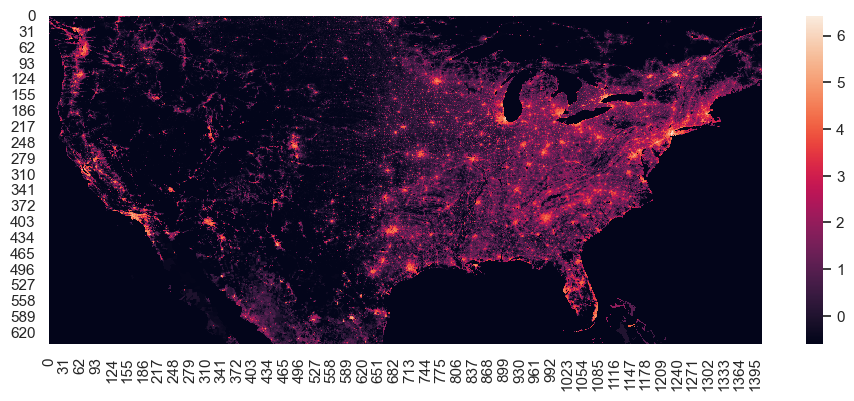

In [15]:
sns.set(rc={'figure.figsize':(11.5,4.25)})
sns.heatmap(reconstruct_grid(full_data[:,0,:,:]))

<Axes: >

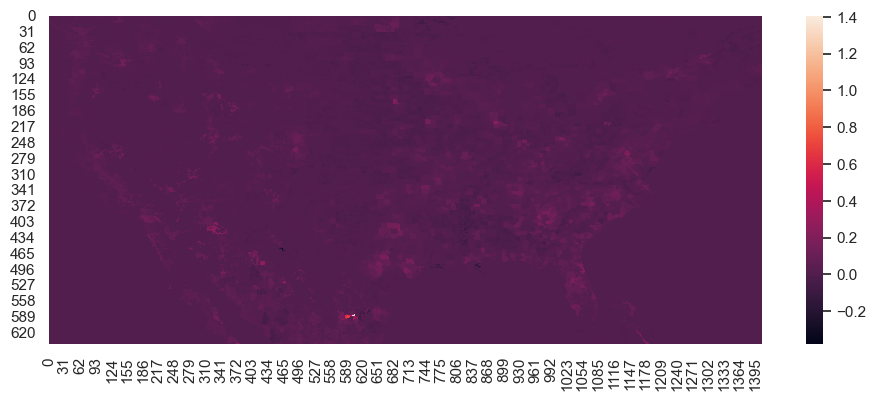

In [16]:
i = 4
sns.heatmap(reconstruct_grid(full_data[:,i,:,:]) - reconstruct_grid(full_data[:,i-1,:,:]))

## CNN-LSTM Attempt

In [11]:
num_epochs = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

def build_mse_model(params, verbose=False):
    window = params['window']
    n_scale_down = params['n_scale_down']
    n_feature = params['n_feature']
    n_filters = params['n_filters']
    kernel_size = params['kernel_size']
    pool_size = params['pool_size']
    activation = params['activation']
    n_lstm_unit = params['n_lstm_unit']
    learning_rate = params['learning_rate']

    ### model using mse as loss function
    model_mse = Sequential()
    model_mse.add(Input(shape=(window, n_scale_down,n_scale_down,n_feature)))
    model_mse.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                        padding='same', activation=activation), input_shape=(window, n_scale_down,n_scale_down,n_feature)))
    model_mse.add(TimeDistributed(AveragePooling2D(pool_size)))
    model_mse.add(TimeDistributed(GlobalAveragePooling2D()))
    model_mse.add(LSTM(n_lstm_unit, activation=activation))
    model_mse.add(Dense(n_scale_down*n_scale_down))
    model_mse.add(Activation('linear'))
    model_mse.add(Reshape((1, n_scale_down, n_scale_down)))


    model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    if verbose:
        model_mse.summary()
    return model_mse

def build_mae_model(params, verbose=False):
    window = params['window']
    n_scale_down = params['n_scale_down']
    n_feature = params['n_feature']
    n_filters = params['n_filters']
    kernel_size = params['kernel_size']
    pool_size = params['pool_size']
    activation = params['activation']
    n_lstm_unit = params['n_lstm_unit']
    learning_rate = params['learning_rate']
    ### ----------------------------------------------------------------------------------------
    ### model using mae as loss function
    model_mae = Sequential()

    model_mae.add(Input(shape=(window, n_scale_down,n_scale_down,n_feature)))
    model_mae.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                        padding='same', activation=activation), input_shape=(window, n_scale_down,n_scale_down,n_feature)))
    model_mae.add(TimeDistributed(AveragePooling2D(pool_size)))
    model_mae.add(TimeDistributed(GlobalAveragePooling2D()))
    model_mae.add(LSTM(n_lstm_unit, activation=activation))
    model_mae.add(Dense(n_scale_down*n_scale_down))
    model_mae.add(Activation('linear'))
    model_mae.add(Reshape((1, n_scale_down, n_scale_down)))


    model_mae.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    if verbose:
        model_mae.summary()
    return model_mae

def train_mse(params, verbose=False):
    model   = build_mse_model(params, verbose)
    history = model.fit(X_train, y_train, 
                        batch_size = params['minibatch_size'],
                        epochs = num_epochs,
                        validation_split=0.2, verbose=verbose,
                        callbacks=[early_stop])
    return model, history
    
def train_mae(params, verbose=False):
    model   = build_mse_model(params, verbose)
    history = model.fit(X_train, y_train, 
                        batch_size = params['minibatch_size'],
                        epochs = num_epochs,
                        validation_split=0.2, verbose=verbose,
                        callbacks=[early_stop])
    return model, history

In [13]:
window_arr          = [4]
#                      16
n_feature_arr       = [1]
n_filters_arr       = [8] # number of filters
kernel_size_arr     = [16]  # kernel size for Covolutional layers
pool_size_arr       = [4]  # size for average pooling layers
activation_arr      = ['relu', 'sigmoid', 'softmax', 'tanh']  # activation function
n_lstm_unit_arr     = [16, 32, 64] # number of LSTM units
learning_rate_arr   = [1e-6] # learning rate
minibatch_size_arr  = [256]   # batch size
param_arr = [window_arr, [n_scale_down], n_feature_arr, n_filters_arr, kernel_size_arr, pool_size_arr, activation_arr, n_lstm_unit_arr, learning_rate_arr, minibatch_size_arr]


# Best from search 2
# (4, 16, 1, 8, 16, 4, 'relu', 16, 1e-06, 256)
# (4, 16, 1, 8, 12, 16, 'relu', 8, 1e-06, 256)
# Best from search 3
# (4, 16, 1, 8, 16, 4, 'relu', 16, 1e-06, 256)
# (4, 16, 1, 8, 12, 16, 'relu', 8, 1e-06, 256)
# Best from search 4
# (4, 16, 1, 8, 16, 4, 'softmax', 16, 1e-06, 256)
# (4, 16, 1, 8, 16, 4, 'softmax', 16, 1e-06, 256)

In [14]:
# param_list = list(itertools.product(*param_arr))
# # (mse, mae)
# loss_list = []
# i = 0
# for param_set in param_list:
#     print("PARAM SET " + str(i + 1) + "/" + str(len(param_list)) + " " + str(param_set))
#     params = {}
#     params['window'] = param_set[0]
#     params['n_scale_down'] = param_set[1]
#     params['n_feature'] = param_set[2]
#     params['n_filters'] = param_set[3]
#     params['kernel_size'] = param_set[4]
#     params['pool_size'] = param_set[5]
#     params['activation'] = param_set[6]
#     params['n_lstm_unit'] = param_set[7]
#     params['learning_rate'] = param_set[8]
#     params['minibatch_size'] = param_set[9]
#     mse_model, mse_history = train_mse(params)
#     mae_model, mae_history = train_mae(params)
#     loss_list.append((mse_history.history['val_loss'][-1], mae_history.history['val_loss'][-1]))
#     print("MSE Loss: " + str(mse_history.history['val_loss'][-1]))
#     print("MAE Loss: " + str(mae_history.history['val_loss'][-1]))
#     i += 1

In [21]:
# mse_losses = []
# mae_losses = []
# for pair in loss_list:
#     mse_losses.append(pair[0])
#     mae_losses.append(pair[1])
# param_search_data = [param_list, mse_losses, mae_losses]
# file_params = open('./local_storage/pop_d_param_search_6.pkl', 'wb')
# pickle.dump(param_search_data, file_params)
# mse_best = (mse_losses.index(min(mse_losses)))
# mae_best = (mae_losses.index(min(mae_losses)))
# print(param_list[mse_best])
# print(param_list[mae_best])

In [12]:
final_params = {}

final_params['window'] = 4
final_params['n_scale_down'] = n_scale_down
final_params['n_feature'] = 1
final_params['n_filters'] = 1
final_params['kernel_size'] = 1
final_params['pool_size'] = 1
final_params['activation'] = 'relu'
final_params['n_lstm_unit'] = 64
final_params['learning_rate'] = 1e-4
final_params['minibatch_size'] = 64
mse_final_model, mse_final_history = train_mse(final_params, verbose=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 4, 16, 16, 1)      2         
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 4, 16, 16, 1)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 4, 1)              0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                       

In [13]:
def project_forward(stop_year, original_data, model):
    data_copy = np.copy(original_data)
    steps = (stop_year - 2020) // 5
    print(steps)
    for step in range(steps):
        next_step = model.predict(data_copy[:,-4:,:,:])
        # print(data_copy.shape, next_step.shape)
        data_copy = np.append(data_copy, next_step, axis=1)
    print("Projected until " + str(2020 + steps * 5))
    return data_copy
    
projection_2050 = project_forward(2050, full_data, mse_final_model)

6
110/110 [==============================] - 0s 1ms/step
Projected until 2050


In [17]:
def produce_gif(data):
    file_names = []
    for i in range(len(data[0])):
        year = int(2000 + i * 5)
        year_data = data[:,i,:,:]
        ax = sns.heatmap(reconstruct_grid(year_data))
        ax.set_title("Log Population Density in " + str(year))
        ax.set(xticklabels=[], yticklabels=[])
        ax.tick_params(bottom=False, left=False)
        fig = ax.get_figure()
        file_name = './figures/population_density/' + str(year) + 'pop_d.png'
        fig.savefig(file_name, dpi=200, bbox_inches='tight')
        file_names.append(file_name)
        fig.clear()
        ax.clear()
    # Gather all PNG files in the current directory
    images = [Image.open(file) for file in file_names]

    # Set the duration for each frame in milliseconds
    duration = 100

    # Save the images as a GIF animation
    images[0].save('./figures/population_density/0_pop_density.gif', save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)
    print(".gif produced at: \'./figures/population_density/0_pop_density.gif\'")
    
produce_gif(projection_2050)

.gif produced at: './figures/population_density/0_pop_density.gif'


<Figure size 1150x425 with 0 Axes>

In [21]:
print(std, mean)

0.64064586 0.38206923


In [22]:
# save 2030 figure for final report
year = 2030
year_data = projection_2050[:,6,:,:] / std + mean
ax = sns.heatmap(reconstruct_grid(year_data))
ax.set_title("Log Population Density in " + str(year))
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
fig = ax.get_figure()
file_name = './final_figures/MISC_figures/PopulationDensity2030CNNLSTM.png'
fig.savefig(file_name, dpi=200, bbox_inches='tight')
fig.clear()
ax.clear()

<Figure size 1150x425 with 0 Axes>

## SVR Time Series Forecasting Attempt

In [8]:
n_scale_down = 1
X     = []
Y     = []
full_data   = []
n_lat = len(clipped_log_data[0]) // n_scale_down
n_lon = len(clipped_log_data[0][0]) // n_scale_down
print(clipped_log_data.shape)
for y in range(len(clipped_log_data[0]) // n_scale_down):
    for x in range(len(clipped_log_data[0][0]) // n_scale_down):
        X.append(clipped_log_data[:4,y,x])
        Y.append(clipped_log_data[4,y,x])
        full_data.append(clipped_log_data[:,y,x])
X = np.array(X)
Y = np.array(Y)
full_data = np.array(full_data)
print(n_lat, n_lon)

(5, 640, 1408)
640 1408


In [27]:
# # tested, rbf works the best!
# kernel_fnc = ['linear', 'rbf', 'sigmoid', 'precomputed']

# for i_kernel in kernel_fnc:
#     # Create and train the SVR model
#     svr_model = SVR(kernel=i_kernel)
#     svr_model.fit(X_train, y_train)

#     score = svr_model.score(X_test, y_test)
#     print("SVR Model Score for " + i_kernel + ":", score)

SVR Model Score (test_split=0.2):  0.9945076236678688
SVR Model Score (test_split=0.5):  0.9946398525809763
SVR Model Score (test_split=0.8):  0.9943187865322083
SVR Model Score (test_split=0.9):  0.99478144932603
SVR Model Score (test_split=0.95):  0.9946297044379699
SVR Model Score (test_split=0.99):  0.9942720668583546
SVR Model Score (test_split=0.999):  0.9924778048975641
SVR Model Score (test_split=0.9999):  0.9851264004624101


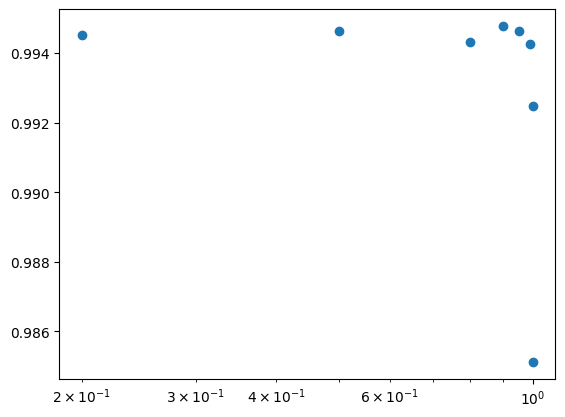

In [11]:
# Find good train-test data split
test_props = [0.20, 0.50, 0.80, 0.90, 0.95, 0.99, 0.999, 0.9999]
test_prop_scores = []
for test_prop in test_props:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_prop)
    svr_model = SVR(kernel='rbf')
    svr_model.fit(X_train, y_train)
    score = svr_model.score(X_test, y_test)
    test_prop_scores.append(score)
    print("SVR Model Score (test_split=" + str(test_prop) + "): ", score)

plt.xscale('log')
plt.scatter(test_props, test_prop_scores)

No significant loss until test_split=0.9999. We will use test_split=0.95 to speed up parameter search.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.95)
svr_model = SVR(kernel='rbf')
params = {"C":[0.1, 1, 10], "gamma": [0.1, 0.01, 0.001]}
# bests params C=1, gamma=0.001
grid_search = GridSearchCV(svr_model, params, verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


KeyboardInterrupt: 

In [13]:
final_svr_model = SVR(kernel='rbf', C=1.0, gamma=0.001)
final_svr_model.fit(X_train, y_train)
score = final_svr_model.score(X_test, y_test)
print("SVR Model Score:", score)

SVR Model Score: 0.9958845820169125


In [14]:
def svr_project_forward(stop_year, original_data, model):
    data_copy = np.copy(original_data)
    steps = (stop_year - 2020) // 5
    standard_min = min(original_data[:,0])
    for step in range(steps):
        next_step = model.predict(data_copy[:,-4:])
        step_min = min(next_step)
        next_step -= step_min - standard_min
        data_copy = np.append(data_copy, np.reshape(next_step, (901120, 1)), axis=1)
    print("Projected until " + str(2020 + steps * 5))
    return data_copy
    
projection_2050 = svr_project_forward(2050, full_data, final_svr_model)

Projected until 2050


In [19]:
print(projection_2050.shape)

(901120, 11)


In [27]:
sns.set(rc={'figure.figsize':(11.5,5)})
print(std, mean)
def svr_produce_gif(data):
    file_names = []
    gif_max = np.max((np.array(data) * std + mean).flatten())
    for i in range(len(data[0])):
        year = int(2000 + i * 5)
        year_data = data[:,i]
        ax = sns.heatmap(reconstruct_grid(year_data) * std + mean, square=True, vmin=0, vmax=gif_max)
        ax.set_title("Log Population Density in " + str(year))
        ax.set(xticklabels=[], yticklabels=[])
        ax.tick_params(bottom=False, left=False)
        fig = ax.get_figure()
        file_name = './figures/population_density/' + str(year) + 'pop_d.png'
        fig.savefig(file_name, dpi=200, bbox_inches='tight')
        file_names.append(file_name)
        fig.clear()
        ax.clear()
    # Gather all PNG files in the current directory
    images = [Image.open(file) for file in file_names]

    # Set the duration for each frame in milliseconds
    duration = 100

    # Save the images as a GIF animation
    images[0].save('./final_figures/Pop_Density/PopDensity.gif', save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)
    print(".gif produced at: \'./final_figures/Pop_Density/PopDensity.gif\'")
    
svr_produce_gif(projection_2050)

0.64064586 0.38206923
.gif produced at: './final_figures/Pop_Density/PopDensity.gif'


<Figure size 1150x500 with 0 Axes>

In [30]:
# format data for saving
final_data = []
for i in range(3):
    final_data.append(reconstruct_grid(projection_2050[:,-3 + i]))

final_lat = np.array(latitudes[lat_max_i:lat_min_i])
final_lon = np.array(longitudes[long_min_i:long_max_i])
final_file = open('./final_datasets/Pop_Density/LatLon.pkl', 'wb')
pickle.dump([final_lat, final_lon], final_file)
final_file.close()
final_file = open('./final_datasets/Pop_Density/PopDensityProjection.pkl', 'wb')
pickle.dump(final_data, final_file)
final_file.close()